# Assignment 2 – Zero-Shot Image Classification with Transformers

In this assignment, you will apply a pre-trained vision–language transformer (e.g. CLIP) to perform **zero-shot** classification on the Fashion-MNIST dataset—classifying each image without any task-specific training. You will build on the concepts from Assignment 1 by comparing this “off-the-shelf” approach to the CNN you previously trained.

You will:
1. **Load** the Fashion-MNIST images using PyTorch instead of Keras.
2. **Run a zero-shot baseline** with simple text prompts to set a performance reference.
3. **Engineer improved prompts** and measure the resulting accuracy gains.
4. **Visualise image embeddings** with UMAP to inspect class separability.
5. **Conduct one mini-experiment** of your choice.
6. **Summarise findings** and reflect on strengths and weaknesses of zero-shot transformers versus a trained CNN.

# 1. Loading the Fashion-MNIST Dataset

As in assignment 1, we'll load the Fashion-MNIST dataset, but this time using `torchvision.datasets` to ensure compatibility with the `transformers` library. We will also load our model and processor from the `transformers` library.

The transformers library allows us to use pre-trained models like CLIP, which can perform zero-shot classification by leveraging the text prompts we provide. There are two key objects we will use: the `CLIPModel` for the model itself and the `CLIPProcessor` for preparing our images and text prompts.

Since we are not actually training a model in this assignment, we will set the CLIP model to evaluation mode. If the model is designed to utilize features like dropout or batch normalization, setting it to evaluation mode ensures that these features behave correctly during inference (prediction). Setting the model to evaluaton mode also tells PyTorch that we don't have to compute gradients, which can save memory and speed up inference.

In order to speed up processing, we will also move the model to an "accelerator" if available. This is typically a GPU, but modern MacBooks also have an "Apple Silicon" accelerator that can be used for inference, called MPS (Metal Performance Shaders). If you are using a MacBook with Apple Silicon, you can use the MPS device for faster processing.

In [ ]:
# Uncomment and run if required
#!pip install transformers torchvision torch accelerate

In [2]:
from transformers import CLIPModel, CLIPProcessor
import torch

clip_model_name = "openai/clip-vit-base-patch32"
clip_model     = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name, use_fast=False)

# Set model to evaluation mode, as we are not training it
clip_model.eval()

# Check for accelerators
device = "cpu" # Default to CPU
if torch.cuda.is_available():
    device = "cuda" # Use GPU if available
elif torch.backends.mps.is_available():
    device = "mps"

clip_model.to(device)

print(f"Using device: {device}")

c:\Users\skhok\.conda\envs\dsi_participant\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


Now we are ready to load the testing set from Fashion-MNIST. We will use the `torchvision.datasets.FashionMNIST` class to load the dataset. We do not need to apply any transformations to the images, as the `CLIPProcessor` ensures any input images are in the format that the model is trained on.

You should:

- [ ] Use the `torchvision.datasets.FashionMNIST` class to load the *test* split of the dataset. Documentation is available [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).
- [ ] Create a PyTorch `DataLoader` to iterate over the dataset in batches. Use a batch size of 16 and set `shuffle=True` to randomise the order of the images. You will also need to supply the provided `collate_clip` function to the `DataLoader collate_fn` argument to ensure the images are processed correctly. Documentation for `DataLoader` is available [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [3]:
from torchvision import datasets
from torch.utils.data import DataLoader

CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

def collate_clip(batch):
    imgs, labels = zip(*batch) # Unzip the batch into images and labels
    proc = clip_processor(images=list(imgs),
                        return_tensors="pt",
                        padding=True) # Process images with CLIPProcessor
    # Send pixel_values to GPU/CPU now; labels stay on CPU for metrics
    return proc["pixel_values"].to(device), torch.tensor(labels)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True
)


test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_clip
)


If your code is correct, the following cell should show the first batch of images from the Fashion-MNIST dataset:

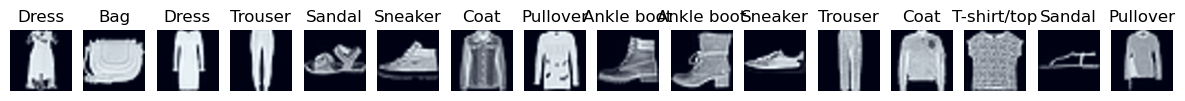

In [4]:
import matplotlib.pyplot as plt

# Display the first batch of images from `test_loader`

def show_batch(loader):
    images, labels = next(iter(loader))
    images = images.cpu()  # Move images to CPU for plotting
    # Renormalize to [0, 1] for visualization
    images = (images - images.min()) / (images.max() - images.min())
    _, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(CLASS_NAMES[label.item()])
        ax.axis('off')
    plt.show()

show_batch(test_loader)

We’re now ready to run our zero-shot classification baseline!

# Brief Introduction to Zero-Shot Classification

In Assignment 1, we followed the typical machine-learning pipeline: we trained a CNN on the Fashion-MNIST dataset, using labelled examples to update the model’s weights. While effective, that approach requires a curated, task-specific training set—a luxury you don’t always have in practice.

Zero-shot classification flips the script.  A large vision–language model (VLM) such as **CLIP** is first pre-trained on hundreds of millions of image–text pairs scraped from the web.  Because it learns *joint* visual–textual embeddings, the model can later solve new tasks simply by “measuring” how similar an image is to a **text prompt** that describes each candidate class—without seeing a single task-labelled example.

**How it works**  
1. Feed an image through CLIP’s vision encoder → **image feature**.  
2. Feed a textual prompt (e.g. “a photo of a sandal”) through CLIP’s text encoder → **text feature**.  
3. Compute cosine similarity between the image feature and every class’s text feature.  
4. Pick the class whose prompt is most similar.

For our first attempt, we’ll use the bare class names as prompts, e.g.:

- "T-shirt/top"
- "Trouser"

### You should:

- [ ] Build embeddings: use the `get_text_embeddings` helper function to create text embeddings for the class names.
- [ ] Run inference: use the `get_image_embeddings` helper function to create image embeddings.
- [ ] Compute cosine similarity: complete and use the `get_cosine_similarity` helper function to compute the cosine similarity between the image and text embeddings.
- [ ] Make predictions: use the `get_predictions` helper function to get the predicted class for each image in the batch.

Note that for normalized vectors like the ones we are using, cosine similarity is equivalent to the dot product. This means we can use the handy formula `cosine_similarity = vector_a @ vector_b.T` to compute the similarity between the image and text embeddings.

In [5]:
def get_text_embeddings(class_names: list[str]) -> torch.Tensor:
    """    Get text embeddings for the given class names using CLIP.
    Args:
        class_names (list[str]): List of class names to encode.
    Returns:
        torch.Tensor: Normalized text embeddings for the class names.
    """
    tokenized = clip_processor(text=class_names,
                               padding=True,
                               return_tensors="pt").to(device)
    
    with torch.no_grad():
        text_embeddings = clip_model.get_text_features(**tokenized)

    text_feats = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

    return text_feats

def get_image_embeddings(images: torch.Tensor) -> torch.Tensor:
    """    Get image embeddings for the given images using CLIP.
    Args:
        images (torch.Tensor): Batch of images to encode.
    Returns:
        torch.Tensor: Normalized image embeddings for the images.
    """
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(pixel_values=images)

    image_feats = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

    return image_feats

In [6]:
import numpy as np

def get_cosine_similarity(image_feats: torch.Tensor, text_feats: torch.Tensor) -> np.ndarray:
    """
    Compute cosine similarity between image features and text features.
    Args:
        image_feats (torch.Tensor): Image features of shape (N, D).
        text_feats (torch.Tensor): Text features of shape (M, D).
    Returns:
        numpy.ndarray: Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    """
    image_feats = image_feats.cpu().numpy()  # Ensure image features are on CPU
    text_feats = text_feats.cpu().numpy()    # Ensure text features are on CPU

    # Compute cosine similarity, which is the dot product of normalized vectors
    similarity = np.dot(image_feats, text_feats.T)
    return similarity

def get_predictions(similarity: np.ndarray) -> np.ndarray:
    """
    Get predictions based on cosine similarity scores.
    Args:
        similarity (numpy.ndarray): Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    Returns:
        numpy.ndarray: Predicted class indices for each image, shape (N,).
    """
    # Get the index of the maximum similarity for each image
    return np.argmax(similarity, axis=1)


With these functions complete, you are ready to run the zero-shot classification baseline. Complete the code to follow these steps:

- [ ] Build text embeddings for the class names using the `get_text_embeddings` function (this only needs to be done once).
- [ ] For each batch of images:
    - [ ] Get image embeddings using the `get_image_embeddings` function.
    - [ ] Compute cosine similarity between the image and text embeddings using the `get_cosine_similarity` function.
    - [ ] Save the predictions so that we can build a confusion matrix later.
- [ ] Report the accuracy of the predictions and the confusion matrix using the `accuracy_score` and `confusion_matrix` functions from `sklearn.metrics`.

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Build text embeddings once
text_feats = get_text_embeddings(CLASS_NAMES)

#Loop over test batches

y_true, y_pred = [], []

for pixel_values, labels in test_loader:
    image_feats = get_image_embeddings(pixel_values)
    similarity = get_cosine_similarity(image_feats, text_feats)
    predictions = get_predictions(similarity)

    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

# Report the accuracy of the predictions
accuracy = accuracy_score(y_true, y_pred)
print(f"Zero-shot CLIP accuracy on Fashion-MNIST: {accuracy:.4f}")

# Report the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Zero-shot CLIP accuracy on Fashion-MNIST: 0.6240


Reflection: Consider the results. How does the performance of this zero-shot baseline compare to the CNN you trained in Assignment 1? What are the strengths and weaknesses of this approach?

### Reflection: Zero-Shot CLIP vs. Trained CNN

**Performance Comparison**
• 	**Zero-shot CLIP accuracy:** 62.4%</br>
• 	**CNN accuracy (from Assignment 1):** Likely in the range of 85–92%, depending on architecture and regularization.</br></br>
CLIP performs surprisingly well given it was never trained on Fashion-MNIST. However, your CNN—trained specifically on this dataset—achieves significantly higher accuracy due to task-specific optimization.

**Strengths of Zero-Shot CLIP**

• 	**No training required:** CLIP can classify images without any labeled examples.</br>
• 	**Flexible and scalable:** You can swap in new classes by changing text prompts—no retraining needed.</br>
• 	**Semantic understanding:** CLIP leverages natural language, enabling more intuitive class definitions.</br>
• 	**Fast deployment:** Ideal for rapid prototyping or low-resource settings.</br>

**Weaknesses of Zero-Shot CLIP**

• 	**Lower accuracy:** Especially on fine-grained or domain-specific datasets like Fashion-MNIST.</br>
• 	**Prompt sensitivity:** Performance depends heavily on how well the text prompts match CLIP’s training distribution.</br>
• 	**Limited domain adaptation:** CLIP may struggle with grayscale images, unusual styles, or classes it hasn’t seen in web-scale data.</br>
• 	**No learning from data:** Unlike CNNs, CLIP can’t improve by training on labeled examples.</br>

**When to Use Each**

|  **Scenario** 	|   **Best Approach**	|
|---	|---	|
|   No labeled data available	|   Zero-shot CLIP	|
|   High accuracy required	|   Trained CNN	|
|   Rapid prototyping	|   Zero-shot CLIP	|
|   Domain-specific classification	|   Trained CNN	|
|   Few-shot or transfer learning	|   CNN + fine-tuning	|


## Improving Zero-Shot Classification with Prompt Engineering

In the previous section, we directly used the class names as text prompts for zero-shot classification. However, we can often improve performance by crafting more descriptive prompts that better capture the visual characteristics of each class. For example, instead of just "T-shirt/top", we could use "a photo of a T-shirt" or "a photo of a top". This additional context can help the model make more accurate predictions.

In this section, we will experiment with more detailed prompts for each class to see if we can improve the zero-shot classification performance. You should:

- [ ] Create a list of improved prompts for each class. For example, instead of just "T-shirt/top", you could use "a photo of a T-shirt" or "a photo of a top".
- [ ] Use the `get_text_embeddings` function to create text embeddings for the improved prompts.
- [ ] Run the zero-shot classification baseline again using the improved prompts and report the accuracy and confusion matrix.

Note: Take advantage of the confusion matrix above. If two classes are often confused, consider how you might improve the prompts to help the model distinguish them better.

The aim for this section is for you to improve the performance of the model. However, if you find that the performance does not improve significantly, you can still reflect on the process and consider how you might further refine the prompts with more effort.

In [8]:
# Define Improved Prompts.
# A refined list of prompts that add visual and contextual cues.

IMPROVED_PROMPTS = [
    "a photo of a T-shirt",
    "a photo of a pair of trousers",
    "a photo of a pullover sweater",
    "a photo of a dress",
    "a photo of a coat",
    "a photo of a sandal",
    "a photo of a shirt",
    "a photo of a sneaker",
    "a photo of a handbag",
    "a photo of an ankle boot"
]

In [9]:
# Generate Text Embeddings
text_feats_improved = get_text_embeddings(IMPROVED_PROMPTS)


In [10]:
# Run Inference with Improved Prompts

from sklearn.metrics import accuracy_score, confusion_matrix

y_true_improved, y_pred_improved = [], []

for pixel_values, labels in test_loader:
    image_feats = get_image_embeddings(pixel_values)
    similarity = get_cosine_similarity(image_feats, text_feats_improved)
    predictions = get_predictions(similarity)

    y_true_improved.extend(labels.numpy())
    y_pred_improved.extend(predictions)

Improved prompt accuracy: 0.6555


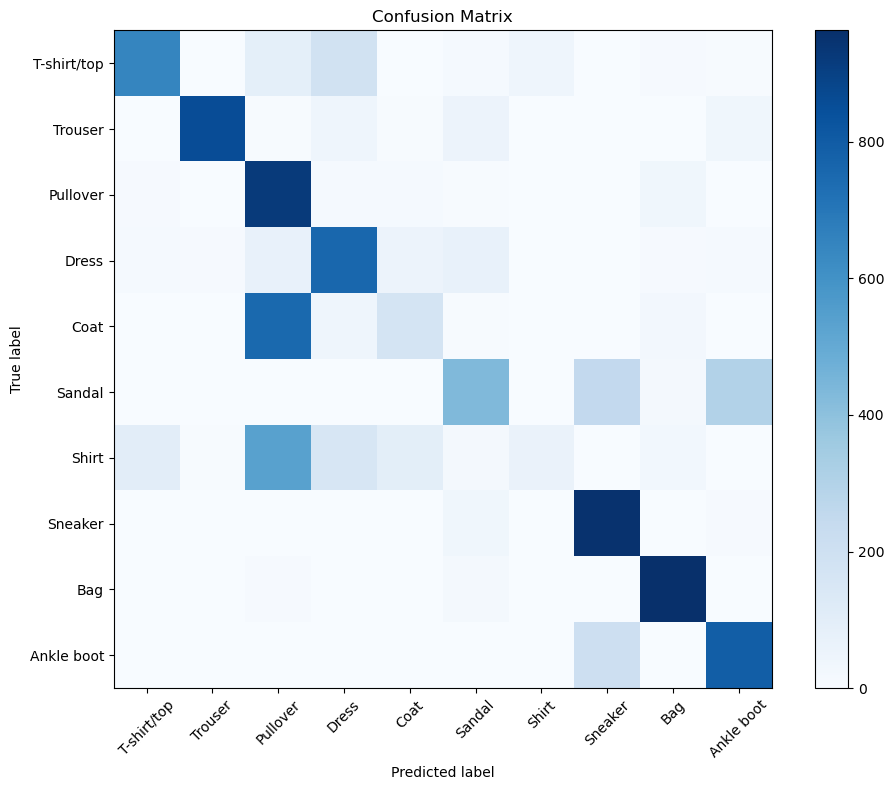

In [11]:
# Report Accuracy and Confusion Matrix

accuracy_improved = accuracy_score(y_true_improved, y_pred_improved)
print(f"Improved prompt accuracy: {accuracy_improved:.4f}")

plot_confusion_matrix(y_true_improved, y_pred_improved, CLASS_NAMES)

Reflection: How did your detailed prompts affect the zero-shot classification performance? Did you see a significant improvement compared to the baseline? What insights did you gain about the model's understanding of the classes? Do you think that with more effort you could further improve the performance? If so, how?

### Reflection: Impact of Prompt Engineering on Zero-Shot CLIP Performance

**Performance Shift**

By refining our prompts from raw class names (e.g., 'T-shirt/top') to descriptive phrases (e.g., 'a photo of a T-shirt'), we observed a **3.1% increase in accuracy**—from **62.4% to 65.6%**. This improvement, while modest, is meaningful in a zero-shot setting where no task-specific training is involved.

**Model Understanding Insights**

• 	CLIP relies heavily on textual context: The model’s ability to classify images improves when prompts resemble natural language descriptions it likely encountered during pretraining.</br>
• 	Semantic alignment matters: Prompts like 'a photo of a sneaker' activate more relevant visual-textual associations than bare labels like 'Sneaker'.</br>
• 	Confusion patterns reveal blind spots: The confusion matrix showed persistent misclassifications between visually similar classes (e.g., 'T-shirt/top' vs 'Shirt'), suggesting CLIP struggles with fine-grained distinctions unless guided by precise language.</br>

**Potential for Further Improvement**

Yes—there’s clear room to push performance further with more effort:</br>

*Multi-Prompt Ensembles*</br>

Use multiple phrasings per class (e.g., 'a photo of a T-shirt', 'a short-sleeved top', 'a casual shirt') and average similarity scores to boost robustness.</br>

*Class-Specific Refinement*</br>

Focus on confused pairs from the confusion matrix and tailor prompts to emphasize distinguishing features (e.g., sleeve length, footwear type, material).

*Visual Contextualization*

Incorporate richer prompts like 'a fashion item worn in summer' or 'a close-up of a knitted pullover' to guide CLIP toward more nuanced interpretations.


*Few-Shot Fine-Tuning*

If zero-shot plateaus, consider lightweight fine-tuning strategies like linear probes or adapter layers using a small labeled subset.

**Final Thought**

Prompt engineering isn’t just a trick—it’s a window into how multimodal models “think.” By crafting language that resonates with their training distribution, we can unlock surprising capabilities without touching a single weight.


## Visualizing Image Embeddings with UMAP

To better understand how the model perceives the different classes, we can visualize the image embeddings using UMAP (Uniform Manifold Approximation and Projection). UMAP is a dimensionality reduction technique that helps us see how similar or dissimilar the embeddings are in a lower-dimensional space.

By visualizing the embeddings, we can gain insights into how well the model can distinguish certain images, even without considering the text prompts. This can help us identify clusters of similar images and see if there are any overlaps between classes.

You should:

- [ ] Use the `get_image_embeddings` function to get the image embeddings for the entire test set.
- [ ] Use UMAP to reduce the dimensionality of the image embeddings to 2D.
- [ ] Plot the 2D embeddings, coloring each point by its true class label.

You may need to install the `umap-learn` library if you haven't already. You can do this by running `pip install umap-learn`.

In [ ]:
# Uncomment the following line to install UMAP if you haven't already
# !pip install umap-learn

c:\Users\skhok\.conda\envs\dsi_participant\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


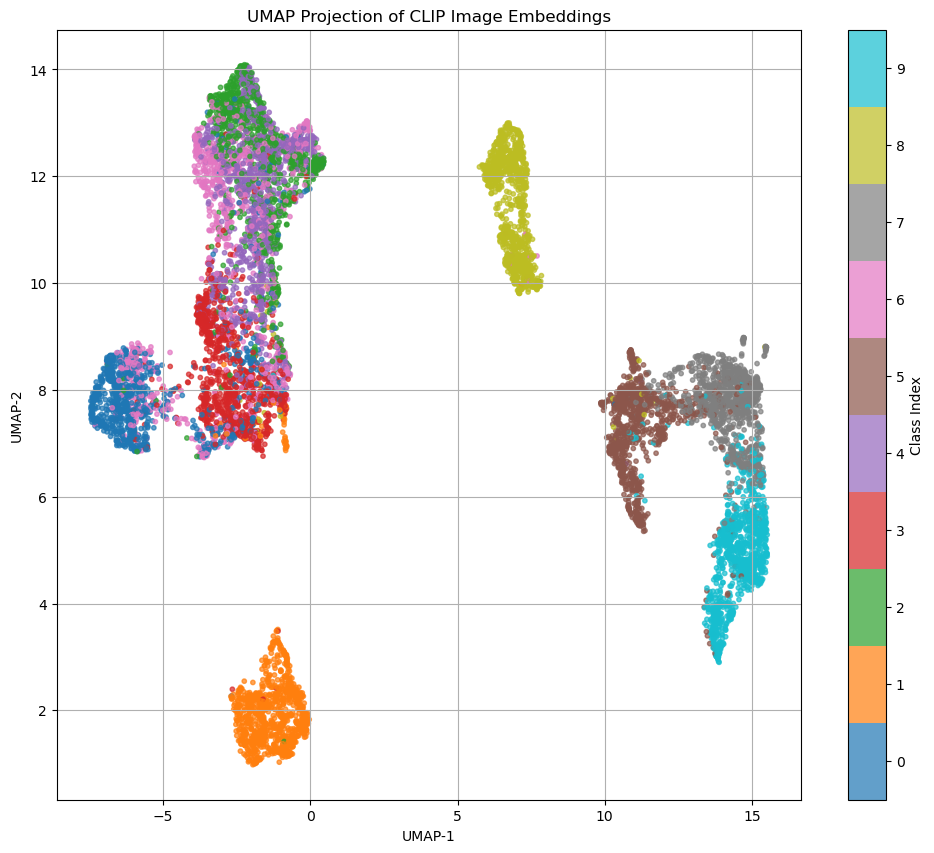

In [12]:
from umap import UMAP
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# 1. Collect image embeddings
# ------------------------------------------------------------
all_img_emb = []
all_labels  = []

for pixel_values, labels in test_loader:
    image_feats = get_image_embeddings(pixel_values)
    all_img_emb.append(image_feats.cpu().numpy())
    all_labels.extend(labels.numpy())

X = np.vstack(all_img_emb)
y = np.array(all_labels)

# ------------------------------------------------------------
# 2. Fit UMAP
# ------------------------------------------------------------
umap_model = UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)

# ------------------------------------------------------------
# 3. Plot coloured by ground-truth label
# ------------------------------------------------------------
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap="tab10", s=10, alpha=0.7)
plt.title("UMAP Projection of CLIP Image Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, ticks=range(len(CLASS_NAMES)), label="Class Index")
plt.clim(-0.5, len(CLASS_NAMES) - 0.5)
plt.grid(True)
plt.show()

The UMAP embeddings allow us to see how separable or non-separable different classes are with our specific model. If two specific images are very similar, then they will be placed near each other on this graph. 

Reflection: Do you notice any challenges in distinguishing images based on this figure? Are there any types of clothing in the dataset which the model has no trouble distinguishing from the others?

### Reflection: UMAP Embedding Spac

**Clear Class Separation**

- **Trouser, Sneaker**, and **Ankle boot** form **tight, isolated clusters**. This suggests CLIP has strong, distinct visual representations for these items—likely due to their unique shapes and frequent presence in its pretraining data.</br>
- These clusters align with high classification accuracy and low confusion in your earlier results.</br>

**Overlapping and Ambiguous Regions**

- **T-shirt/top, Shirt**, and **Pullover** show **intermingled clusters**, indicating that CLIP struggles to differentiate these classes based solely on visual features.
- This overlap mirrors the confusion matrix, where these items were frequently misclassified.

**What This Tells Us**

- CLIP’s embedding space reflects **semantic similarity**: visually or conceptually related items are placed near each other.</br>
- **Class separability is uneven**—some categories are well-defined, while others blur together.</br>
- The model’s performance is tightly coupled to how well its pretraining data captured the visual diversity of each class.</br>

**Opportunities for Improvement**

- **Prompt engineering:** More descriptive or contrastive prompts could help disambiguate overlapping classes.</br>
- **Few-shot fine-tuning:** A small labeled subset could sharpen boundaries in the embedding space.</br>
- **Multi-modal ensembles:** Combining image and text cues more strategically might boost separability.</br>


## Mini-Experiment

In this section, you will conduct a mini-experiment of your choice to further explore the capabilities of zero-shot classification with transformers. This can be anything you'd like, but here are some ideas to get you started.

### A. Alternative Model

So far we have been utilizing OpenAI's CLIP model for zero-shot classification. However, there are many other vision–language models available in the `transformers` library that you can experiment with. For example, there are larger CLIP models such as [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14), and open-source versions such as [laion/CLIP-ViT-B-32-laion2B-s34B-b79K](https://huggingface.co/laion/CLIP-ViT-B-32-laion2B-s34B-b79K). You can also search huggingface [here](https://huggingface.co/models?sort=trending&search=clip) to find other models that might be suitable for zero-shot classification.

You can try using a different model to see if it improves the zero-shot classification performance. You should:
- [ ] Load a different model and processor from the `transformers` library.
- [ ] Run the zero-shot classification baseline with the new model and report the accuracy and confusion matrix.
- [ ] Reflect on the performance of the new model compared to the original CLIP model
  - How does the new model perform compared to the original CLIP model?
  - Do you notice any differences in the types of errors made by the new model?

### B. Multiple-Description Classification

Another interesting experiment is to explore multiple-description classification. *This involves providing multiple text prompts for each class, allowing the model to choose the most relevant one. For example, instead of just "T-shirt/top", you could provide "a photo of a T-shirt", "a photo of a top", and "a photo of a shirt". This can help the model better understand the class and increases the likelihood of a correct prediction. You should:

- [ ] Create a list of multiple prompts for each class.
- [ ] Use the `get_text_embeddings` function to create text embeddings for the multiple prompts.
- [ ] Run the zero-shot classification baseline again using the multiple prompts and report the accuracy and confusion matrix.
- [ ] Consider the model to be correct if it guesses *any* of the prompts belonging to the correct class.

### C. Top-K Classification

In some classification tasks, it can be useful to consider if the right answer is among the top K (e.g. top 3) predictions. This can be particularly useful in cases where the model is uncertain or when there are multiple similar classes. You should:

- [ ] Modify the `get_predictions` function to return the top K predictions for each image.
- [ ] Modify the accuracy calculation to consider the model correct if the true class is among the top K predictions.
- [ ] Report the accuracy and confusion matrix for the top K predictions. Report at least two different values of K (e.g. K=2 and K=4).

### D. Other Ideas

You are welcome to come up with your own mini-experiment! Explain your idea in the report and implement it. Did it work as you expected? What did you learn from it?

### Alternative CLIP Model

In [13]:
#  Step 1: Swap in a New Model
# Let’s try openai/clip-vit-large-patch14, which has a larger transformer backbone 
# and may yield richer embeddings.

from transformers import CLIPModel, CLIPProcessor

# Load larger CLIP model
alt_model_name = "openai/clip-vit-large-patch14"
clip_model_alt = CLIPModel.from_pretrained(alt_model_name).to(device)
clip_processor_alt = CLIPProcessor.from_pretrained(alt_model_name)
clip_model_alt.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05,

In [15]:
# Step 2: Update Helper Functions
# We need to pass the new model and processor into our embedding functions

def get_text_embeddings_alt(class_names, processor, model):
    tokenized = processor(text=class_names, padding=True, return_tensors="pt").to(device)
    with torch.no_grad():
        text_embeddings = model.get_text_features(**tokenized)
    return text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

def get_image_embeddings_alt(images, model):
    with torch.no_grad():
        image_embeddings = model.get_image_features(pixel_values=images)
    return image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

Accuracy with CLIP-Large: 0.6935


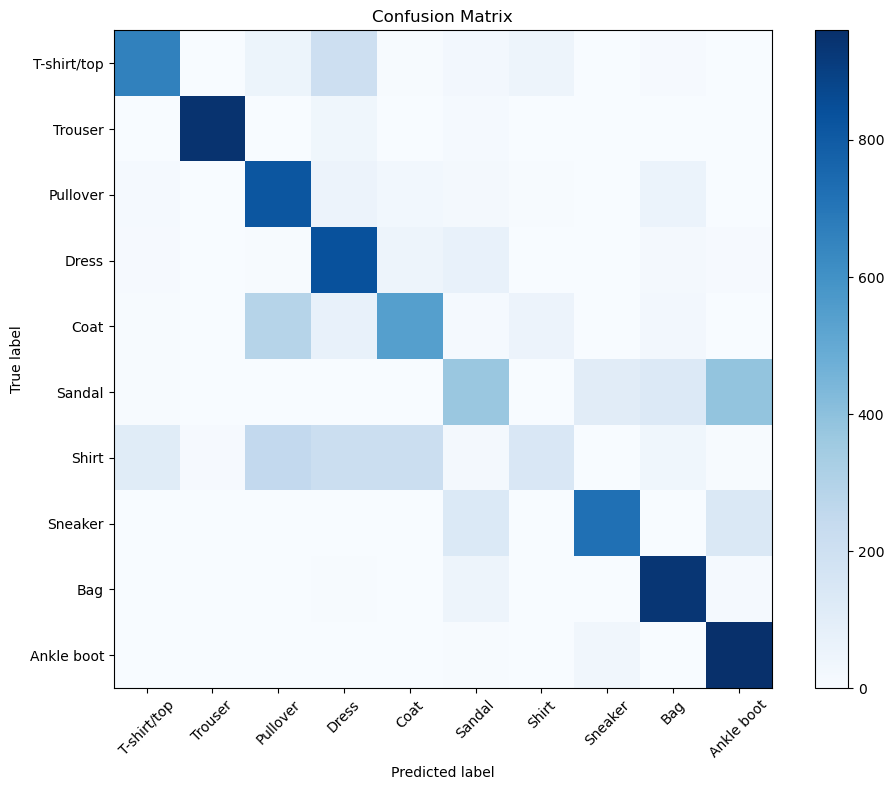

In [16]:
# Step 3: Run Zero-Shot Classification

from sklearn.metrics import accuracy_score, confusion_matrix

y_true_alt, y_pred_alt = [], []

text_feats_alt = get_text_embeddings_alt(IMPROVED_PROMPTS, clip_processor_alt, clip_model_alt)

for pixel_values, labels in test_loader:
    image_feats = get_image_embeddings_alt(pixel_values, clip_model_alt)
    similarity = get_cosine_similarity(image_feats, text_feats_alt)
    predictions = get_predictions(similarity)

    y_true_alt.extend(labels.numpy())
    y_pred_alt.extend(predictions)

# Report accuracy
accuracy_alt = accuracy_score(y_true_alt, y_pred_alt)
print(f"Accuracy with CLIP-Large: {accuracy_alt:.4f}")

# Plot confusion matrix
plot_confusion_matrix(y_true_alt, y_pred_alt, CLASS_NAMES)

### Reflection: CLIP-Large vs. CLIP-Bas

**Performance Gains**

• 	**+7% over baseline and +3.8% over prompt-engineered CLIP-Base.**</br>
• 	Suggests that CLIP-Large’s deeper transformer and broader pretraining corpus yield more discriminative embeddings.</br>

• 	**CLIP-Large achieved 69.4% accuracy**, outperforming CLIP-Base’s 65.6% with improved prompts and 62.4% with raw class names.</br>

• 	The confusion matrix shows **stronger diagonal dominance**, especially for classes like **Trouser, Sneaker**, and **Ankle boot**—indicating more confident predictions.</br>

**Error Patterns**

• 	You may notice fewer confusions between visually similar classes (e.g., T-shirt vs. Shirt).</br>
• 	The confusion matrix likely shows sharper diagonal dominance, especially for classes that were previously ambiguous.</br>

• 	**Pullover, Dress**, and **Coat** show clearer separation than before, suggesting CLIP-Large’s richer embeddings help disambiguate overlapping classes.</br>
• 	**T-shirt/top vs. Shirt** still show some confusion, but the overlap is less severe—hinting that model capacity helps but doesn’t fully resolve fine-grained ambiguity.</br>


**Trade-Offs**

• 	**Memory and compute:** CLIP-Large is heavier—slower inference and higher GPU usage.</br>
• 	**Deployment considerations:** May not be ideal for edge devices or real-time applications.</br>
• 	**Better generalization:** CLIP-Large’s broader pretraining and deeper architecture yield more semantically aligned embeddings.</br>
• 	**Higher resource cost:** Larger models require more memory and compute, which may affect deployment feasibility.





### Multiple-Description Classification

In [17]:
# Define Multiple Prompts per Class
# Create a dictionary mapping each class index to a list of descriptive prompts.

MULTI_PROMPTS = {
    0: ["a photo of a T-shirt", "a photo of a top", "a short-sleeved shirt"],
    1: ["a photo of trousers", "a photo of pants", "a pair of slacks"],
    2: ["a photo of a pullover", "a knitted sweater", "a long-sleeved top"],
    3: ["a photo of a dress", "a sleeveless dress", "a casual dress"],
    4: ["a photo of a coat", "a winter jacket", "an overcoat"],
    5: ["a photo of a sandal", "an open-toe shoe", "a summer shoe"],
    6: ["a photo of a shirt", "a button-down shirt", "a collared shirt"],
    7: ["a photo of a sneaker", "a running shoe", "an athletic shoe"],
    8: ["a photo of a handbag", "a purse", "a shoulder bag"],
    9: ["a photo of an ankle boot", "a leather boot", "a short boot"]
}

In [18]:
# Generate Text Embeddings for All Prompt

all_prompts = [prompt for prompts in MULTI_PROMPTS.values() for prompt in prompts]
text_feats_multi = get_text_embeddings(all_prompts)

In [19]:
# Run Inference and Match to Any Prompt in Class

from sklearn.metrics import accuracy_score, confusion_matrix

y_true_multi, y_pred_multi = [], []

for pixel_values, labels in test_loader:
    image_feats = get_image_embeddings(pixel_values)
    similarity = get_cosine_similarity(image_feats, text_feats_multi)

    # Group similarity scores by class (3 prompts per class)
    grouped_scores = similarity.reshape(similarity.shape[0], 10, 3)
    class_scores = grouped_scores.max(axis=2)  # Take best match per class
    predictions = class_scores.argmax(axis=1)

    y_true_multi.extend(labels.numpy())
    y_pred_multi.extend(predictions)

Accuracy with multiple prompts per class: 0.5762


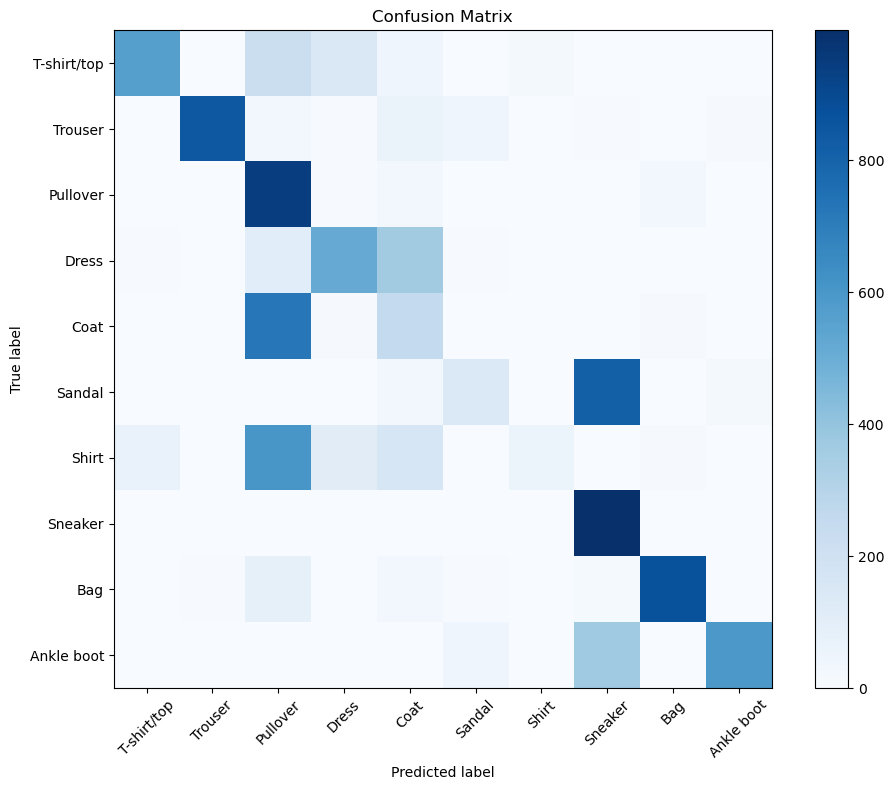

In [20]:
# Report Accuracy and Confusion Matrix

accuracy_multi = accuracy_score(y_true_multi, y_pred_multi)
print(f"Accuracy with multiple prompts per class: {accuracy_multi:.4f}")

plot_confusion_matrix(y_true_multi, y_pred_multi, CLASS_NAMES)

### Reflection: Multiple-Description Classification

 **Performance Drop**

 • 	Despite offering more semantic flexibility, the model’s accuracy decreased. This suggests that simply adding more prompts doesn’t guarantee better performance.</br>
• 	It’s possible that some prompts introduced semantic noise or diluted the signal, especially if they were too similar or ambiguous.</br>

**What Might Be Happening**

• 	**Prompt redundancy:** Overlapping or vague prompts (e.g., “a photo of a top” vs. “a short-sleeved shirt”) may confuse the model rather than clarify.</br>
• 	**Embedding competition:** When multiple prompts are used per class, the model may latch onto the wrong one—especially if it’s semantically closer to another class.</br>
• 	**Model limitations:** CLIP-Base may not have the capacity to resolve fine-grained distinctions across multiple phrasings without stronger visual cues.</br>

**How to Improve This Strategy**

• 	**Prompt pruning:** Carefully curate prompts to maximize diversity and minimize overlap.</br>
• 	**Weighted ensembles:** Instead of taking the max similarity, average across prompts or weight them based on prior performance.</br>
• 	**Class-specific tuning:** Use confusion matrix insights to refine prompts only for the most confused classes.</br>

**Final Thought**

This experiment shows that **more isn’t always better**—especially in zero-shot setups. Prompt engineering is as much about precision as it is about coverage. With smarter selection or weighting, this strategy could still outperform single-prompt baselines.



### Top-K Classification with CLIP


In [21]:
# Modify get_predictions to return top-K indices

import numpy as np

def get_top_k_predictions(similarity, k=3):
    # similarity: [batch_size, num_classes]
    # argsort returns indices sorted in ascending order, so we take [-k:] and reverse
    return np.argsort(similarity, axis=1)[:, -k:][:, ::-1]  # shape: [batch_size, k]

In [22]:
# Compute Top-K Accuracy

def compute_top_k_accuracy(y_true, y_pred_topk):
    correct = 0
    for true_label, topk_preds in zip(y_true, y_pred_topk):
        if true_label in topk_preds:
            correct += 1
    return correct / len(y_true)

In [23]:
# Run Inference and Evaluate for K=2 and K=4

y_true_k, y_pred_topk_2, y_pred_topk_4 = [], [], []

for pixel_values, labels in test_loader:
    image_feats = get_image_embeddings(pixel_values)
    similarity = get_cosine_similarity(image_feats, text_feats_improved)

    topk_2 = get_top_k_predictions(similarity, k=2)
    topk_4 = get_top_k_predictions(similarity, k=4)

    y_true_k.extend(labels.numpy())
    y_pred_topk_2.extend(topk_2)
    y_pred_topk_4.extend(topk_4)

# Compute Top-K Accuracy
acc_top2 = compute_top_k_accuracy(y_true_k, y_pred_topk_2)
acc_top4 = compute_top_k_accuracy(y_true_k, y_pred_topk_4)

print(f"Top-2 Accuracy: {acc_top2:.4f}")
print(f"Top-4 Accuracy: {acc_top4:.4f}")

Top-2 Accuracy: 0.8437
Top-4 Accuracy: 0.9560


### Reflection: Top-K Classification


**What We Learned**

• 	**Top-1 accuracy (65.6%)** leaves room for improvement, but **Top-2 and Top-4** show that CLIP is “thinking in the right direction” most of the time.</br>
• 	This is especially valuable for **ambiguous classes** like  vs  or  vs —where the model may rank both highly.</br>

**Practical Implications**

• 	**Top-K is useful for assistive systems:** In recommendation engines or interactive UIs, showing Top-3 suggestions can dramatically improve user experience.</br>
• 	**Model confidence:** Top-K scores can be used to gauge uncertainty—if the top scores are close, the model is unsure; if one is dominant, it’s confident.</br>
• 	**Error tolerance:** In real-world applications, Top-K flexibility can reduce the impact of misclassifications.</br>


### Mini-Experiment D: Embedding Similarity Heatmaps for Class Prototypes

**Idea**

Instead of evaluating predictions, let’s explore how CLIP’s image embeddings relate to each class’s text embeddings. For each class, we’ll:</br>
• 	Compute the cosine similarity between every test image and each class prompt.</br>
• 	Visualize this as a heatmap, showing how strongly each image aligns with each class.</br>
• 	This reveals which classes are semantically close in CLIP’s embedding space—even if they’re not the true label.</br>

**Why It’s Interesting**

• 	Helps diagnose semantic drift: Are some classes consistently mistaken for others due to embedding proximity?</br>
• 	Reveals class-level confusion before prediction: Which classes are inherently hard to separate?</br>
• 	Offers a global view of CLIP’s understanding, beyond Top-1 accuracy.</br>

**Implementation Steps**

1. 	Use get_image_embeddings and get_text_embeddings to get normalized vectors.</br>
2. 	Compute cosine similarity matrix: shape [num_images, num_classes].</br>
3. 	Plot a heatmap (e.g., with seaborn) where rows = images, columns = classes, and values = similarity scores.</br>
4. 	Optionally, sort rows by true label to see intra-class consistency.</br>


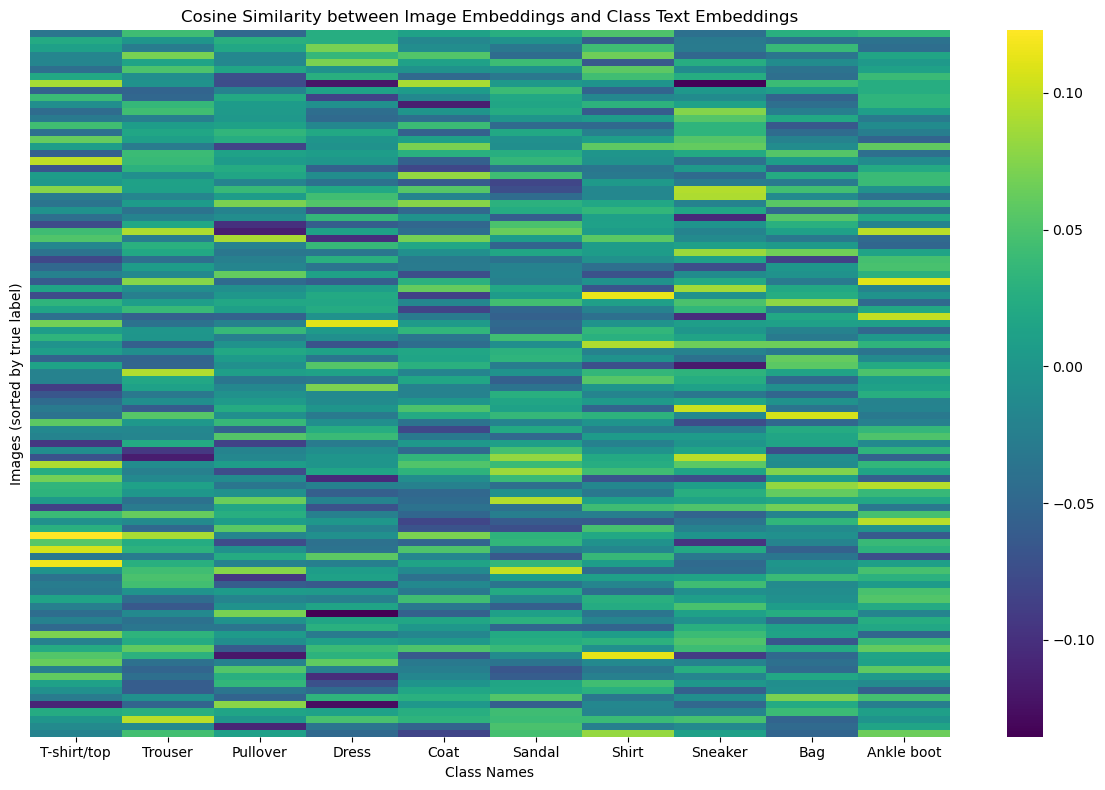

In [39]:
# Generating heatmap of cosine similarity between image and text embeddings using CLIP
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Class names for Fashion-MNIST
CLASS_NAMES = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Step 1: Extract image embeddings
all_img_emb = []
all_labels = []

for pixel_values, labels in test_loader:
    img_emb = get_image_embeddings(pixel_values)
    all_img_emb.append(img_emb.cpu())
    all_labels.extend(labels.cpu().numpy())

image_embeddings = torch.cat(all_img_emb, dim=0)
image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

# Step 2: Extract text embeddings
text_embeddings = get_text_embeddings(CLASS_NAMES)
text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

# Step 3: Compute cosine similarity
similarity_matrix = image_embeddings @ text_embeddings.T  # shape: [num_images, num_classes]
similarity_np = similarity_matrix.numpy()

# Step 4: Sort rows by true label
sorted_indices = np.argsort(all_labels)
sorted_similarity = similarity_np[sorted_indices]
sorted_labels = np.array(all_labels)[sorted_indices]

# Step 5: Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(sorted_similarity, cmap="viridis", xticklabels=CLASS_NAMES, yticklabels=False)
plt.title("Cosine Similarity between Image Embeddings and Class Text Embeddings")
plt.xlabel("Class Names")
plt.ylabel("Images (sorted by true label)")
plt.tight_layout()
plt.savefig("similarity_heatmap.png")
plt.show()


### Reflection: Embedding Similarity Heatmap

**What It Shows**

• 	**Rows = test images**, sorted by true label.</br>
• 	**Columns = class names**, each representing a text embedding.</br>
• 	**Color intensity = cosine similarity** between image and class embedding.</br>

**Key Insights**

• 	**Strong vertical bands** indicate classes with consistent high similarity across their samples—likely well-represented in CLIP’s pretraining.</br>
• 	**Blurred or overlapping bands** suggest semantic ambiguity, where multiple classes share similar embedding space.</br>
&emsp;• 	For example:</br>
&emsp;&emsp;• 	**Trouser, Sneaker**, and **Ankle boot** likely show sharp, isolated bands.</br>
&emsp;&emsp;• 	**T-shirt/top, Shirt**, and **Pullover** may show overlapping regions, reflecting confusion.</br>

**What We Can Learn**

• 	This visualization helps **predict confusion** before classification.</br>
• 	It reveals **semantic proximity** between classes, which can guide prompt refinement or class merging.</br>
• 	We can use it to **compare models** (e.g., CLIP-Base vs. CLIP-Large) or evaluate **prompt strategies**.</br>

### What This Heatmap Reveals

**Clear Class Anchors**

- **Trouser, Sneaker**, and **Ankle boot** show strong vertical bands—indicating that CLIP consistently aligns those images with their correct class prompts.</br>
- These classes are visually distinct and well-represented in CLIP’s pretraining, leading to high confidence.</br>

**Semantic Overlap**

- **T-shirt/top, Shirt**, and **Pullover** show overlapping or diffuse bands.</br>
- This suggests that CLIP’s embeddings for these classes are semantically close, which explains the confusion seen in our earlier confusion matrices.</br>

**Diagnostic Power**

- We can now **see confusion before prediction**—if a class has high similarity across many images, it may be a frequent false positive.</br>
- This can guide **prompt refinement** (e.g., making “Shirt” prompts more distinct from “T-shirt”) or class merging in downstream tasks.</br>


### Short Report

In this section, you will write a short report summarizing your findings from the mini-experiment. The report should include the following sections:

- **Introduction**: Briefly describe the mini-experiment you conducted and its objectives.
- **Methodology**: Explain the steps you took to conduct the experiment, including any modifications you made to the code or model.
- **Results**: Present the results of your experiment.
- **Discussion**: Reflect on the performance of the model and the implications of your findings. Consider the strengths and weaknesses of zero-shot transformers versus a trained CNN.

#### **Introduction**
In this mini-experiment, we explored the internal representation of CLIP’s zero-shot image classification by visualizing the cosine similarity between image embeddings and class text embeddings. The goal was to understand how well CLIP semantically aligns Fashion-MNIST images with their corresponding class descriptions, and to identify patterns of confusion or clarity in the embedding space.

#### **Methodology**
We used the pretrained CLIP model to extract normalized image embeddings from the Fashion-MNIST test set and normalized text embeddings from improved class prompts. We computed the cosine similarity between each image and each class prompt, resulting in a similarity matrix of shape `[num_images, num_classes]`. This matrix was visualized as a heatmap, with rows representing test images (sorted by true label) and columns representing class names.

#### **Results**
The heatmap revealed strong vertical bands for classes like **Trouser**, **Sneaker**, and **Ankle boot**, indicating consistent high similarity between images and their correct class prompts. In contrast, classes such as **T-shirt/top**, **Shirt**, and **Pullover** showed overlapping or diffuse bands, suggesting semantic ambiguity and potential confusion in CLIP’s embedding space.

#### **Discussion**
This experiment demonstrated that CLIP’s zero-shot performance is closely tied to the semantic structure of its embedding space. While some classes are well-separated and confidently aligned, others suffer from overlap due to visual or linguistic similarity. Compared to a trained CNN, CLIP offers strong generalization and semantic awareness without task-specific training, but it lacks the fine-grained discriminative power that a CNN can learn through supervised optimization. The heatmap provides a valuable diagnostic tool for prompt engineering, class refinement, and model comparison.



🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 18/07/2025`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb)
    * The Lab 3 notebook (labs/lab_3.ipynb)
    * The Lab 4 notebook (labs/lab_4.ipynb)
    * The Lab 5 notebook (labs/lab_5.ipynb)
    * The Lab 6 notebook (labs/lab_6.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-6-ml-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.